In [ ]:
#@title Download data

!sudo apt-get install megatools -q
!megadl "https://mega.nz/file/6Z0ACBoY#vLaITj97VOWwuV_ZIta-TN0iGBISFvmXbto6iC7B0H4"
!megadl "https://mega.nz/file/WMlEnBQC#6GN8U7gu7jxsNC6Fcvs35FL8lqCx904M9N14mTmWP8o"
!megadl "https://mega.nz/file/fJtn3SpY#pI0U6CXtOfvvKWJuGKTjqjL2_D837TaBTPrfdOCu280"
!wget https://raw.githubusercontent.com/ZygoOoade/conceptual_spaces/main/StyleGAN/smiling_faces.csv

Reading package lists...
Building dependency tree...
Reading state information...
megatools is already the newest version (1.10.3-1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.

ERROR: Download failed for 'https://mega.nz/file/6Z0ACBoY#vLaITj97VOWwuV_ZIta-TN0iGBISFvmXbto6iC7B0H4': Can't rename donwloaded temporary file /content/.megatmp.6Z0ACBoY to /content/folder.zip (downloaded data are good!): Error moving file /content/.megatmp.6Z0ACBoY: File exists
Downloaded sad_faces.csv

ERROR: Download failed for 'https://mega.nz/file/fJtn3SpY#pI0U6CXtOfvvKWJuGKTjqjL2_D837TaBTPrfdOCu280': Can't rename donwloaded temporary file /content/.megatmp.fJtn3SpY to /content/overlap.csv (downloaded data are good!): Error moving file /content/.megatmp.fJtn3SpY: File exists
--2025-07-31 17:38:11--  https://raw.githubusercontent.com/ZygoOoade/conceptual_spaces/main/StyleGAN/smiling_faces.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.1

In [ ]:
import zipfile
import os
zip_path = "/content/folder.zip"
extract_path = "/content/data"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Unzip : {extract_path}")

Unzip : /content/data


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Custom Dataset class for efficient loading
class FaceLatentDataset(Dataset):
    def __init__(self, smile_df, sad_df, data_dir):
        self.data_dir = data_dir
        self.samples = []

        # Process smiling faces
        for _, row in smile_df.iterrows():
            self.samples.append({
                'id': self.extract_id(row['filename']),
                'label': 1.0,
                'weight': float(row['confidence'])
            })

        # Process sad faces
        for _, row in sad_df.iterrows():
            self.samples.append({
                'id': self.extract_id(row['full_path']),
                'label': 0.0,  # Using 0 for BCEWithLogitsLoss
                'weight': float(row['emotion_confidence'])
            })

    def extract_id(self, id_value):
        id_str = str(id_value).strip()
        if '/' in id_str or '\\' in id_str:
            id_str = os.path.splitext(os.path.basename(id_str))[0]
        return id_str

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        vector_id = sample['id']

        # Try different filename formats
        for filename in [f'{vector_id}.npy', f'{vector_id.zfill(5)}.npy']:
            vector_path = os.path.join(self.data_dir, filename)
            if os.path.exists(vector_path):
                latent_vector = np.load(vector_path)  # Shape: (1, 16, 512)
                latent_vector = latent_vector.reshape(-1)  # Flatten to (8192,)
                return {
                    'vector': torch.FloatTensor(latent_vector),
                    'label': torch.FloatTensor([sample['label']]),
                    'weight': torch.FloatTensor([sample['weight']])
                }

        # If file not found, return zeros (will be filtered out)
        return None

# Linear model
class LinearClassifier(nn.Module):
    def __init__(self, input_dim=8192):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(input_dim, 1, bias=False)  # No bias for direction vector

    def forward(self, x):
        return self.linear(x)

# Collate function to handle None values
def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None
    return {
        'vector': torch.stack([item['vector'] for item in batch]),
        'label': torch.stack([item['label'] for item in batch]),
        'weight': torch.stack([item['weight'] for item in batch])
    }

# Load data
print("Loading CSV files...")
smiling_faces = pd.read_csv('/content/smiling_faces.csv')
sad_faces = pd.read_csv('/content/sad_faces.csv')
overlap = pd.read_csv('/content/overlap.csv')

# Filter overlaps
overlap_ids = set(overlap['Overlapping_Identifiers'].tolist())
smiling_faces_filtered = smiling_faces[~smiling_faces['filename'].isin(overlap_ids)]
sad_faces_filtered = sad_faces[~sad_faces['full_path'].isin(overlap_ids)]

print(f"Smiling faces: {len(smiling_faces_filtered)}")
print(f"Sad faces: {len(sad_faces_filtered)}")

# Find data directory
data_dir = None
for path in ['/content/data/', 'data/', './data/']:
    if os.path.exists(path):
        data_dir = path
        break

if data_dir is None:
    raise ValueError("Data directory not found")

print(f"Data directory: {data_dir}")

# Create dataset and dataloader
dataset = FaceLatentDataset(smiling_faces_filtered, sad_faces_filtered, data_dir)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn, num_workers=2)

# Initialize model
model = LinearClassifier().to(device)
print(f"Model initialized on {device}")

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss(reduction='none')  # No reduction to apply weights
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 1000
best_loss = float('inf')

print("\nStarting training...")
for epoch in range(num_epochs):
    epoch_loss = 0.0
    epoch_weight = 0.0
    num_batches = 0

    model.train()
    for batch in dataloader:
        if batch is None:
            continue

        # Move to GPU
        vectors = batch['vector'].to(device)
        labels = batch['label'].to(device)
        weights = batch['weight'].to(device)

        # Forward pass
        outputs = model(vectors)

        # Calculate weighted loss
        loss = criterion(outputs, labels)
        weighted_loss = (loss * weights).mean()

        # Backward pass
        optimizer.zero_grad()
        weighted_loss.backward()
        optimizer.step()

        epoch_loss += weighted_loss.item()
        epoch_weight += weights.sum().item()
        num_batches += 1

    # Print progress
    if (epoch + 1) % 50 == 0:
        avg_loss = epoch_loss / num_batches if num_batches > 0 else 0
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

        if avg_loss < best_loss:
            best_loss = avg_loss

print("\nTraining completed!")

# Extract smile direction
model.eval()
with torch.no_grad():
    # Get the weight vector from the linear layer
    direction = model.linear.weight.data.cpu().numpy().flatten()  # Shape: (8192,)

    # Normalize to unit length
    direction_norm = np.linalg.norm(direction)
    smile_direction = direction / direction_norm

    print(f"\nDirection statistics:")
    print(f"Original norm: {direction_norm:.6f}")
    print(f"Normalized norm: {np.linalg.norm(smile_direction):.6f}")
    print(f"Direction shape: {smile_direction.shape}")

    # Display first 10 components
    print("\nFirst 10 components of smile direction:")
    for i in range(10):
        print(f"Component {i}: {smile_direction[i]:.6f}")

    # Reshape back to original shape and save
    smile_direction_reshaped = smile_direction.reshape(1, 16, 512)
    np.save('/content/smile_direction.npy', smile_direction_reshaped)
    print(f"\nSmile direction saved to '/content/smile_direction.npy' with shape {smile_direction_reshaped.shape}")

# Validation function
def apply_smile(latent_vector, intensity):
    """
    Apply the smile transformation to a latent vector.

    Args:
        latent_vector: numpy array of shape (1, 16, 512) - the original latent vector
        intensity: float - the intensity of the smile transformation
                  positive values increase smile, negative values increase sadness

    Returns:
        w_new: numpy array of shape (1, 16, 512) - the transformed latent vector
    """
    # Load the smile direction if not already in memory
    smile_dir = np.load('/content/smile_direction.npy')  # Shape: (1, 16, 512)

    # Apply the transformation
    w_new = latent_vector + intensity * smile_dir

    return w_new

# Quick validation on training data
print("\n=== Validation ===")
model.eval()
all_outputs = []
all_labels = []
all_weights = []

with torch.no_grad():
    for batch in dataloader:
        if batch is None:
            continue
        vectors = batch['vector'].to(device)
        labels = batch['label']
        weights = batch['weight']

        outputs = torch.sigmoid(model(vectors)).cpu()
        all_outputs.extend(outputs.numpy().flatten())
        all_labels.extend(labels.numpy().flatten())
        all_weights.extend(weights.numpy().flatten())

all_outputs = np.array(all_outputs)
all_labels = np.array(all_labels)
all_weights = np.array(all_weights)

# Calculate metrics
smile_mask = all_labels == 1.0
sad_mask = all_labels == 0.0

print(f"\nAverage prediction for smiling faces: {all_outputs[smile_mask].mean():.3f}")
print(f"Average prediction for sad faces: {all_outputs[sad_mask].mean():.3f}")
print(f"Separation: {all_outputs[smile_mask].mean() - all_outputs[sad_mask].mean():.3f}")

# Weighted accuracy
predictions = (all_outputs > 0.5).astype(float)
accuracy = np.sum((predictions == all_labels) * all_weights) / np.sum(all_weights)
print(f"Weighted accuracy: {accuracy:.3f}")

print("\nScript completed successfully!")

Using device: cuda
GPU: Tesla T4
Loading CSV files...
Smiling faces: 8344
Sad faces: 4786
Data directory: /content/data/
Model initialized on cuda

Starting training...
Epoch [50/1000], Loss: 0.1812
Epoch [100/1000], Loss: 0.1795
Epoch [150/1000], Loss: 0.1814
Epoch [200/1000], Loss: 0.1769
Epoch [250/1000], Loss: 0.1858
Epoch [300/1000], Loss: 0.1832
Epoch [350/1000], Loss: 0.1826
Epoch [400/1000], Loss: 0.1894
Epoch [450/1000], Loss: 0.1861
Epoch [500/1000], Loss: 0.1830
Epoch [550/1000], Loss: 0.1808
Epoch [600/1000], Loss: 0.1826
Epoch [650/1000], Loss: 0.1815
Epoch [700/1000], Loss: 0.1833
Epoch [750/1000], Loss: 0.1815
Epoch [800/1000], Loss: 0.1856
Epoch [850/1000], Loss: 0.1782
Epoch [900/1000], Loss: 0.1787
Epoch [950/1000], Loss: 0.1793
Epoch [1000/1000], Loss: 0.1840

Training completed!

Direction statistics:
Original norm: 1.884476
Normalized norm: 1.000000
Direction shape: (8192,)

First 10 components of smile direction:
Component 0: 0.007652
Component 1: -0.005605
Compon

In [ ]:
!pip install ninja
!git clone https://github.com/NVlabs/stylegan3.git
!wget -nc -O stylegan3/stylegan3-t-ffhq-1024x1024.pkl https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-t-ffhq-1024x1024.pkl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 24.8 MB/s eta 0:00:00
Cloning into 'stylegan3'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 212 (delta 99), reused 90 (delta 90), pack-reused 49 (from 1)
Receiving objects: 100% (212/212), 4.16 MiB | 16.91 MiB/s, done.
Resolving deltas: 100% (108/108), done.
--2025-07-31 18:44:48--  https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-t-ffhq-1024x1024.pkl
Resolving api.ngc.nvidia.com (api.ngc.nvidia.com)... 35.164.198.191, 34.212.233.123
Connecting to api.ngc.nvidia.com (api.ngc.nvidia.com)|35.164.198.191|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://xfiles.ngc.nvidia.com/org/nvidia/team/research/models/stylegan3/versions/1/files/stylegan3-t-ffhq-1024x1024.pkl?ssec-algo=AES256&versionId=Pq0TsLpbrJL8kNRN4xGQsr_DcEvFQ4xJ&ssec-key=phwKBJToZvXuil0U

Loading model from: stylegan3/stylegan3-t-ffhq-1024x1024.pkl...
Model loaded successfully.
Model expects W vectors of shape: (1, 16, 512)

Loading smile direction from: /content/smile_direction.npy...
Smile direction shape: (1, 16, 512)

Generating random W vectors...
Setting up PyTorch plugin "bias_act_plugin"... 

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.
Generated 3 W vectors

Generating images with different smile intensities...

Processing sample 1/3
Setting up PyTorch plugin "filtered_lrelu_plugin"... 

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.

Processing sample 2/3

Processing sample 3/3


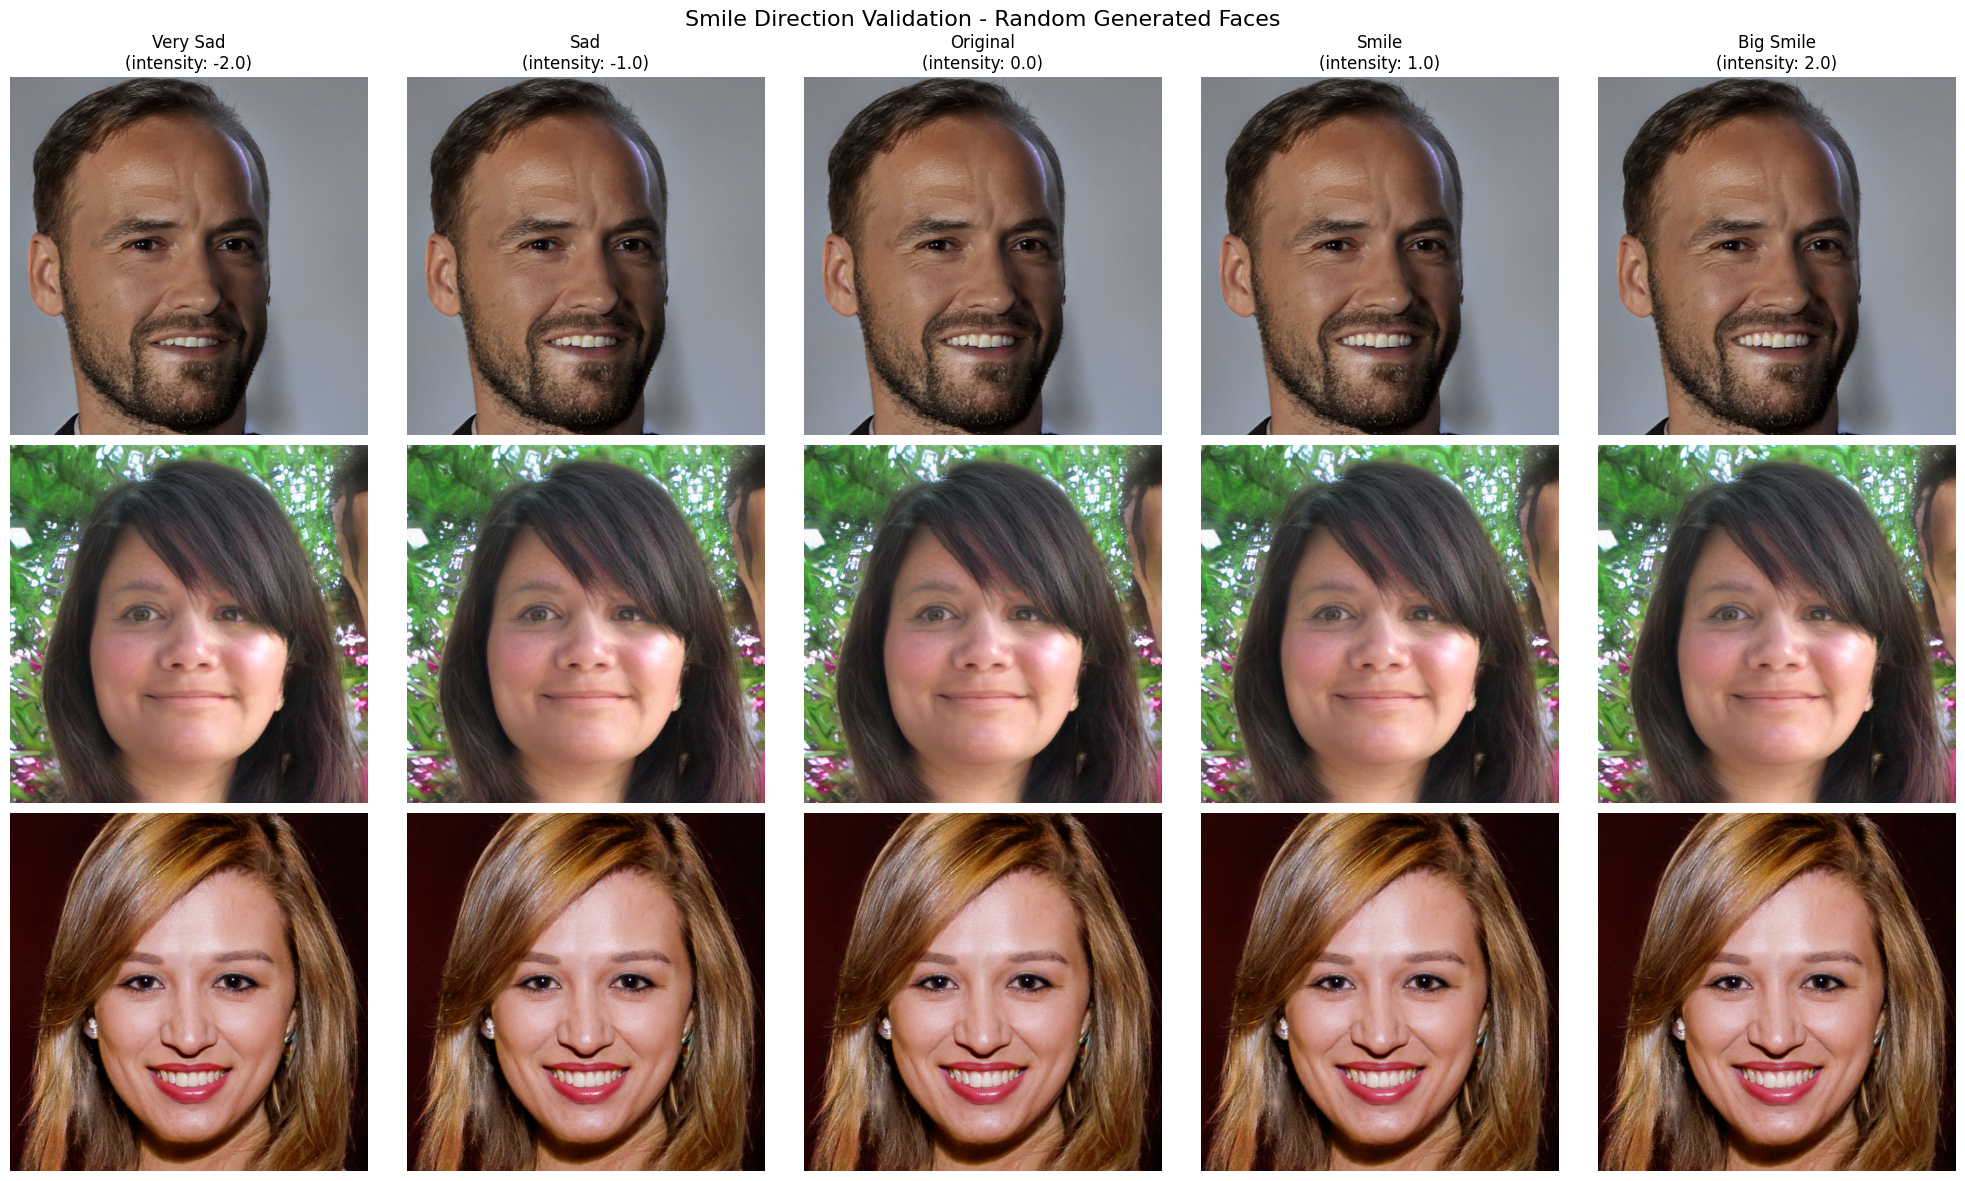



Generating fine-grained intensity example...


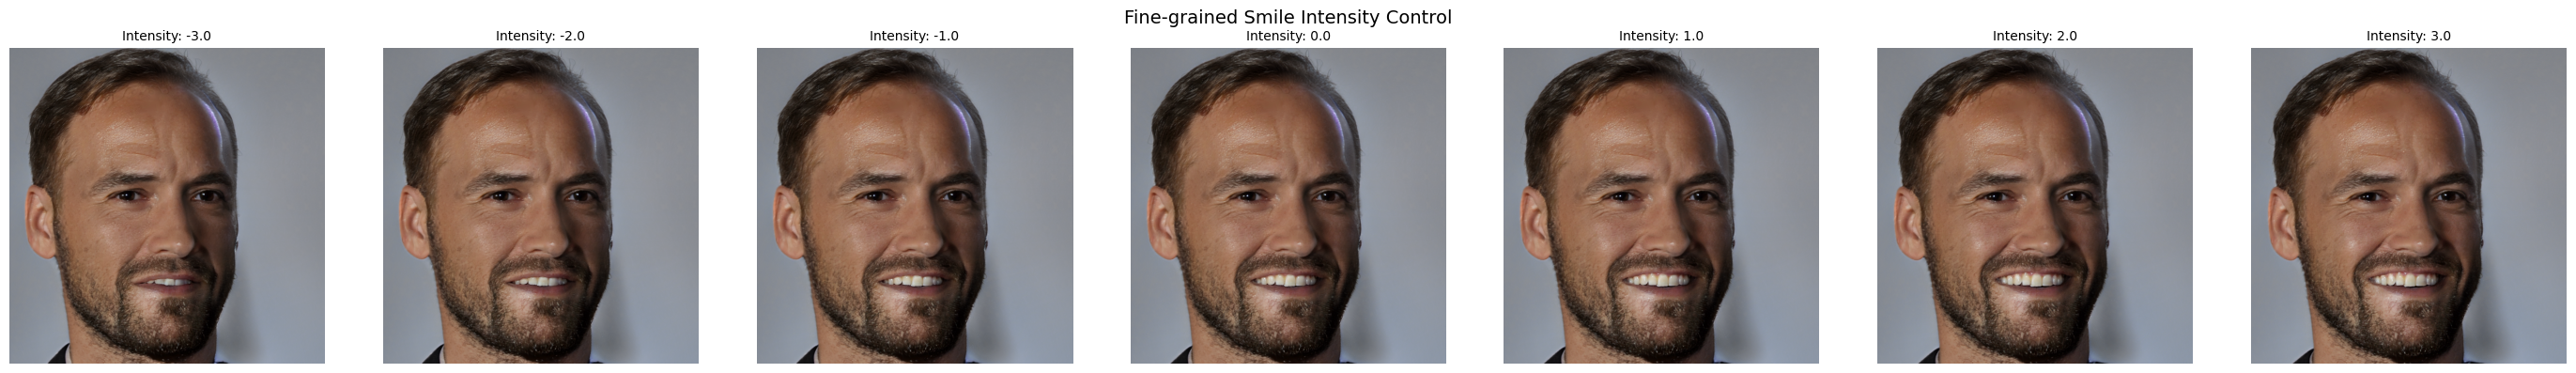



Testing on existing latent vectors from dataset...


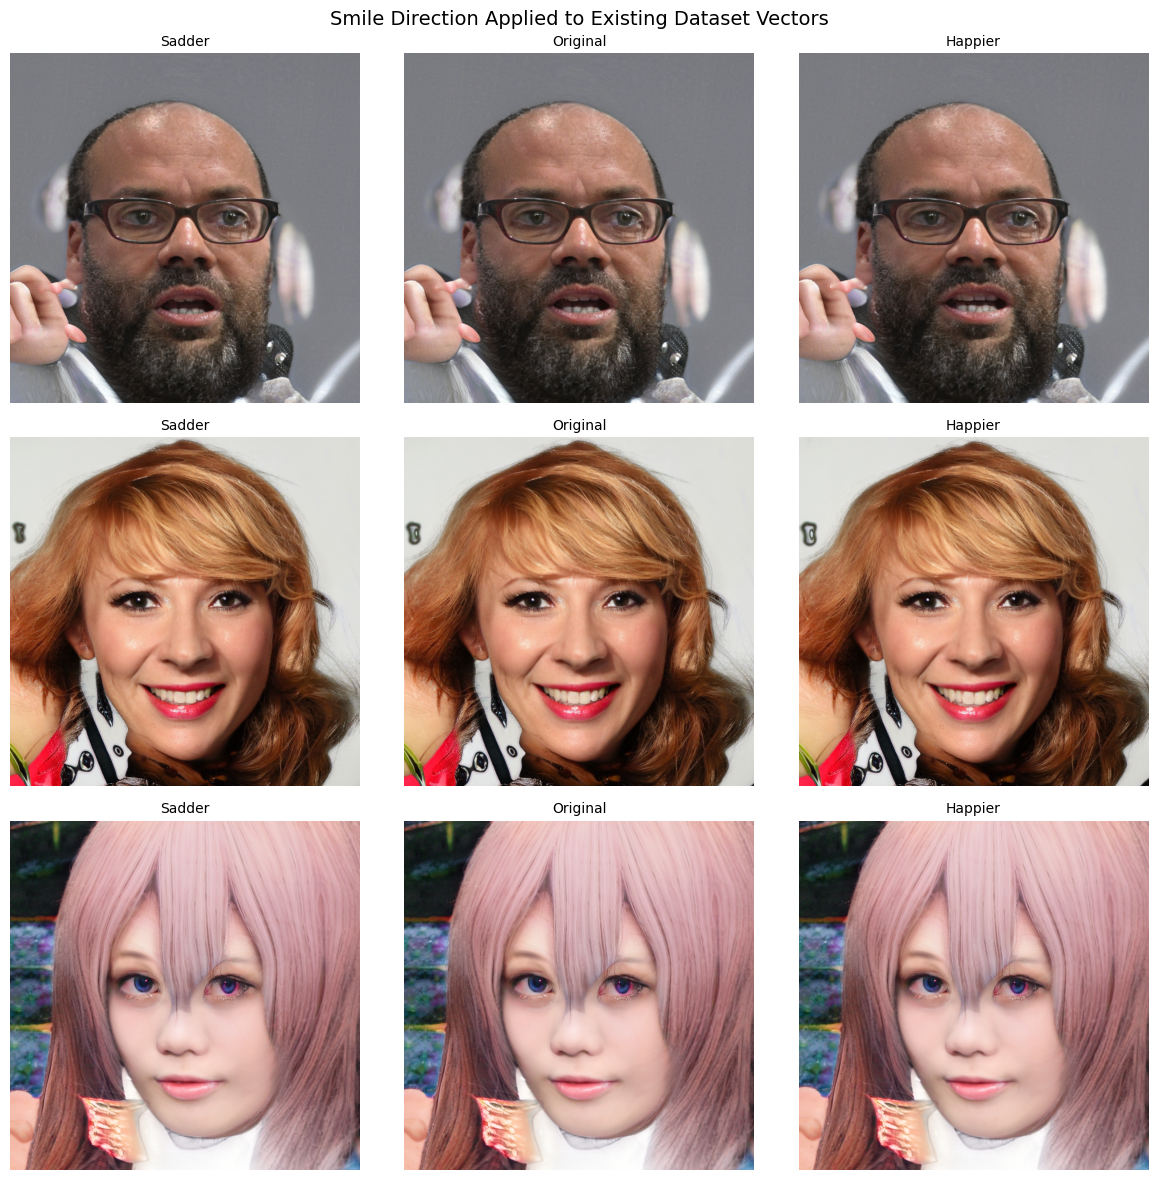



Validation complete!
Generated images saved to:
  - /content/smile_validation.png
  - /content/smile_fine_grained.png
  - /content/smile_existing_vectors.png

You can also use test_smile_on_vector('/path/to/vector.npy') to test on specific vectors


In [ ]:
import torch
import numpy as np
import os
import sys
from PIL import Image
import matplotlib.pyplot as plt

sys.path.append('stylegan3')

import dnnlib
import legacy

# --- 1. Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = 'stylegan3/stylegan3-t-ffhq-1024x1024.pkl'
smile_direction_path = '/content/smile_direction.npy'

# --- 2. Load the StyleGAN3 Model ---
print(f"Loading model from: {model_path}...")
with dnnlib.util.open_url(model_path) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device)
print("Model loaded successfully.")
print(f"Model expects W vectors of shape: (1, {G.num_ws}, {G.w_dim})")

# --- 3. Load the smile direction ---
print(f"\nLoading smile direction from: {smile_direction_path}...")
smile_direction = np.load(smile_direction_path)
print(f"Smile direction shape: {smile_direction.shape}")

# --- 4. Generate random W vectors ---
print("\nGenerating random W vectors...")

# To generate W vectors, we need to:
# 1. Generate random Z vectors
# 2. Pass them through the mapping network

num_samples = 3
z_dim = G.z_dim

# Generate random Z vectors
z_vectors = np.random.randn(num_samples, z_dim)

# Convert to W space using the mapping network
w_vectors = []
for i in range(num_samples):
    z = torch.from_numpy(z_vectors[i:i+1]).to(device).float()
    # Use the mapping network to convert Z to W
    w = G.mapping(z, None)  # shape: (1, num_ws, w_dim)
    w_vectors.append(w.cpu().numpy())

print(f"Generated {num_samples} W vectors")

# --- 5. Apply smile transformation and generate images ---
# Define intensity levels to test
intensities = [-2.0, -1.0, 0.0, 1.0, 2.0]
intensity_labels = ['Very Sad', 'Sad', 'Original', 'Smile', 'Big Smile']

# Create figure for visualization
fig, axes = plt.subplots(num_samples, len(intensities), figsize=(20, 12))
if num_samples == 1:
    axes = axes.reshape(1, -1)

print("\nGenerating images with different smile intensities...")

for sample_idx in range(num_samples):
    print(f"\nProcessing sample {sample_idx + 1}/{num_samples}")

    # Get the base W vector
    w_base = w_vectors[sample_idx]  # shape: (1, num_ws, w_dim)

    for intensity_idx, intensity in enumerate(intensities):
        # Apply smile transformation
        w_transformed = w_base + intensity * smile_direction

        # Convert to tensor and generate image
        ws = torch.from_numpy(w_transformed).to(device).float()

        # Generate image
        img_tensor = G.synthesis(ws, noise_mode='const')

        # Post-process
        img_tensor = (img_tensor + 1) * (255 / 2)
        img_tensor = img_tensor.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)
        img_numpy = img_tensor[0].cpu().numpy()

        # Display in subplot
        axes[sample_idx, intensity_idx].imshow(img_numpy)
        axes[sample_idx, intensity_idx].axis('off')

        # Add title only to first row
        if sample_idx == 0:
            axes[sample_idx, intensity_idx].set_title(
                f'{intensity_labels[intensity_idx]}\n(intensity: {intensity})',
                fontsize=12
            )

plt.suptitle('Smile Direction Validation - Random Generated Faces', fontsize=16)
plt.tight_layout()
plt.savefig('/content/smile_validation.png', dpi=150, bbox_inches='tight')
plt.show()

# --- 6. Generate a single example with more fine-grained intensities ---
print("\n\nGenerating fine-grained intensity example...")

# Use the first random face
w_base = w_vectors[0]

# More intensity levels
fine_intensities = np.linspace(-3, 3, 7)
fig, axes = plt.subplots(1, len(fine_intensities), figsize=(28, 4))

for idx, intensity in enumerate(fine_intensities):
    # Apply transformation
    w_transformed = w_base + intensity * smile_direction
    ws = torch.from_numpy(w_transformed).to(device).float()

    # Generate image
    img_tensor = G.synthesis(ws, noise_mode='const')

    # Post-process
    img_tensor = (img_tensor + 1) * (255 / 2)
    img_tensor = img_tensor.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)
    img_numpy = img_tensor[0].cpu().numpy()

    # Display
    axes[idx].imshow(img_numpy)
    axes[idx].axis('off')
    axes[idx].set_title(f'Intensity: {intensity:.1f}', fontsize=10)

plt.suptitle('Fine-grained Smile Intensity Control', fontsize=14)
plt.tight_layout()
plt.savefig('/content/smile_fine_grained.png', dpi=150, bbox_inches='tight')
plt.show()

# --- 7. Test on existing latent vectors if available ---
print("\n\nTesting on existing latent vectors from dataset...")

# Try to load a few existing vectors
data_dir = '/content/data/'
existing_files = [f for f in os.listdir(data_dir) if f.endswith('.npy')][:3]

if existing_files:
    fig, axes = plt.subplots(len(existing_files), 3, figsize=(12, 4*len(existing_files)))
    if len(existing_files) == 1:
        axes = axes.reshape(1, -1)

    for file_idx, filename in enumerate(existing_files):
        # Load existing W vector
        w_existing = np.load(os.path.join(data_dir, filename))

        # Test three intensities
        test_intensities = [-1.5, 0, 1.5]
        test_labels = ['Sadder', 'Original', 'Happier']

        for int_idx, (intensity, label) in enumerate(zip(test_intensities, test_labels)):
            # Apply transformation
            w_transformed = w_existing + intensity * smile_direction
            ws = torch.from_numpy(w_transformed).to(device).float()

            # Generate image
            img_tensor = G.synthesis(ws, noise_mode='const')

            # Post-process
            img_tensor = (img_tensor + 1) * (255 / 2)
            img_tensor = img_tensor.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)
            img_numpy = img_tensor[0].cpu().numpy()

            # Display
            axes[file_idx, int_idx].imshow(img_numpy)
            axes[file_idx, int_idx].axis('off')
            axes[file_idx, int_idx].set_title(f'{label}', fontsize=10)

            if int_idx == 0:
                axes[file_idx, int_idx].set_ylabel(f'Vector: {filename}', rotation=90, fontsize=10)

    plt.suptitle('Smile Direction Applied to Existing Dataset Vectors', fontsize=14)
    plt.tight_layout()
    plt.savefig('/content/smile_existing_vectors.png', dpi=150, bbox_inches='tight')
    plt.show()

print("\n\nValidation complete!")
print("Generated images saved to:")
print("  - /content/smile_validation.png")
print("  - /content/smile_fine_grained.png")
if existing_files:
    print("  - /content/smile_existing_vectors.png")

# --- 8. Helper function for interactive use ---
def test_smile_on_vector(vector_path, intensities=[-2, -1, 0, 1, 2]):
    """
    Test smile direction on a specific latent vector

    Args:
        vector_path: Path to the .npy file containing W vector
        intensities: List of intensity values to test
    """
    # Load vector
    w = np.load(vector_path)

    # Generate images
    fig, axes = plt.subplots(1, len(intensities), figsize=(4*len(intensities), 4))

    for idx, intensity in enumerate(intensities):
        w_transformed = w + intensity * smile_direction
        ws = torch.from_numpy(w_transformed).to(device).float()

        img_tensor = G.synthesis(ws, noise_mode='const')
        img_tensor = (img_tensor + 1) * (255 / 2)
        img_tensor = img_tensor.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)
        img_numpy = img_tensor[0].cpu().numpy()

        axes[idx].imshow(img_numpy)
        axes[idx].axis('off')
        axes[idx].set_title(f'Intensity: {intensity}')

    plt.suptitle(f'Smile transformation on {os.path.basename(vector_path)}')
    plt.tight_layout()
    plt.show()

print("\nYou can also use test_smile_on_vector('/path/to/vector.npy') to test on specific vectors")